# NMI & ARI Test Routine

## Compute Descriptors

In [141]:
%load_ext autoreload
%autoreload 2

import numpy as np

from descriptor_utils import DescriptorWrapper
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from experiment_utils import compute_knn, plot_evaluation
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics.pairwise import rbf_kernel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = np.load("point_clouds/all_point_clouds.npz", allow_pickle=True)
point_clouds = data['objects']
labels = data['labels']

In [49]:
descriptor_wrapper = DescriptorWrapper()
descriptor_list = ['evrap', 'sirm', 'scomp', 'samp', 'sector_model', 'shell_model', 'combined_model', 'pfh']
descriptor_embeddings = dict()

In [50]:
for descriptor in descriptor_list:
    desc_output = descriptor_wrapper.compute_model_on_dataset(point_clouds, descriptor)
    descriptor_embeddings[descriptor] = desc_output

In [51]:
df = pd.DataFrame({k: list(v) for k, v in descriptor_embeddings.items()})

## Run Test Routine

In [171]:
descriptors = [['evrap', 'samp', 'sirm', 'scomp'], ['pfh'], ['sector_model'], ['combined_model'], ['shell_model'],
               ['evrap'], ['samp'], ['sirm'], ['scomp']]
knn_types = ['mutual', 'symmetric']

plot_data_nmi_ari = {
    metric_type: {
        metric: { '_'.join(descriptor): [] for descriptor in descriptors }
        for metric in ['nmi', 'ari']
    }
    for metric_type in knn_types
}
plot_data_nmi_ari['cluster_size'] = []  # Add cluster size key

cluster_size = range(2, 21)
n_neighbors = 15
mode = 'connectivity'
for c in cluster_size:
    plot_data_nmi_ari['cluster_size'].append(c)
    for variant in knn_types:
        for descriptor in descriptors:
            knn_graph = compute_knn(df, descriptor_list=descriptor, n_neighbors=n_neighbors, variant=variant, mode=mode)
            
            if mode == 'distance':
                # for numerical stability
                knn_graph += 1e-10
                knn_graph = knn_graph / np.max(knn_graph)
                sigma = 1.0  # Adjust sigma as needed
                knn_graph = rbf_kernel(knn_graph, gamma=1 / (2 * sigma**2))

            spectral = SpectralClustering(
                    n_clusters=c,
                    affinity='precomputed',
                    random_state=42,
                    n_jobs=-1
            )
            predicted_labels = spectral.fit_predict(knn_graph)
            nmi = normalized_mutual_info_score(labels, predicted_labels)
            ari = adjusted_rand_score(labels, predicted_labels)
    
            plot_data_nmi_ari[variant]['nmi']['_'.join(descriptor)].append(nmi)
            plot_data_nmi_ari[variant]['ari']['_'.join(descriptor)].append(ari)

/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarnin

In [172]:
weighted = ''
if mode == 'distance':
    weighted = 'weighted'
else:
    weighted = 'unweighted'

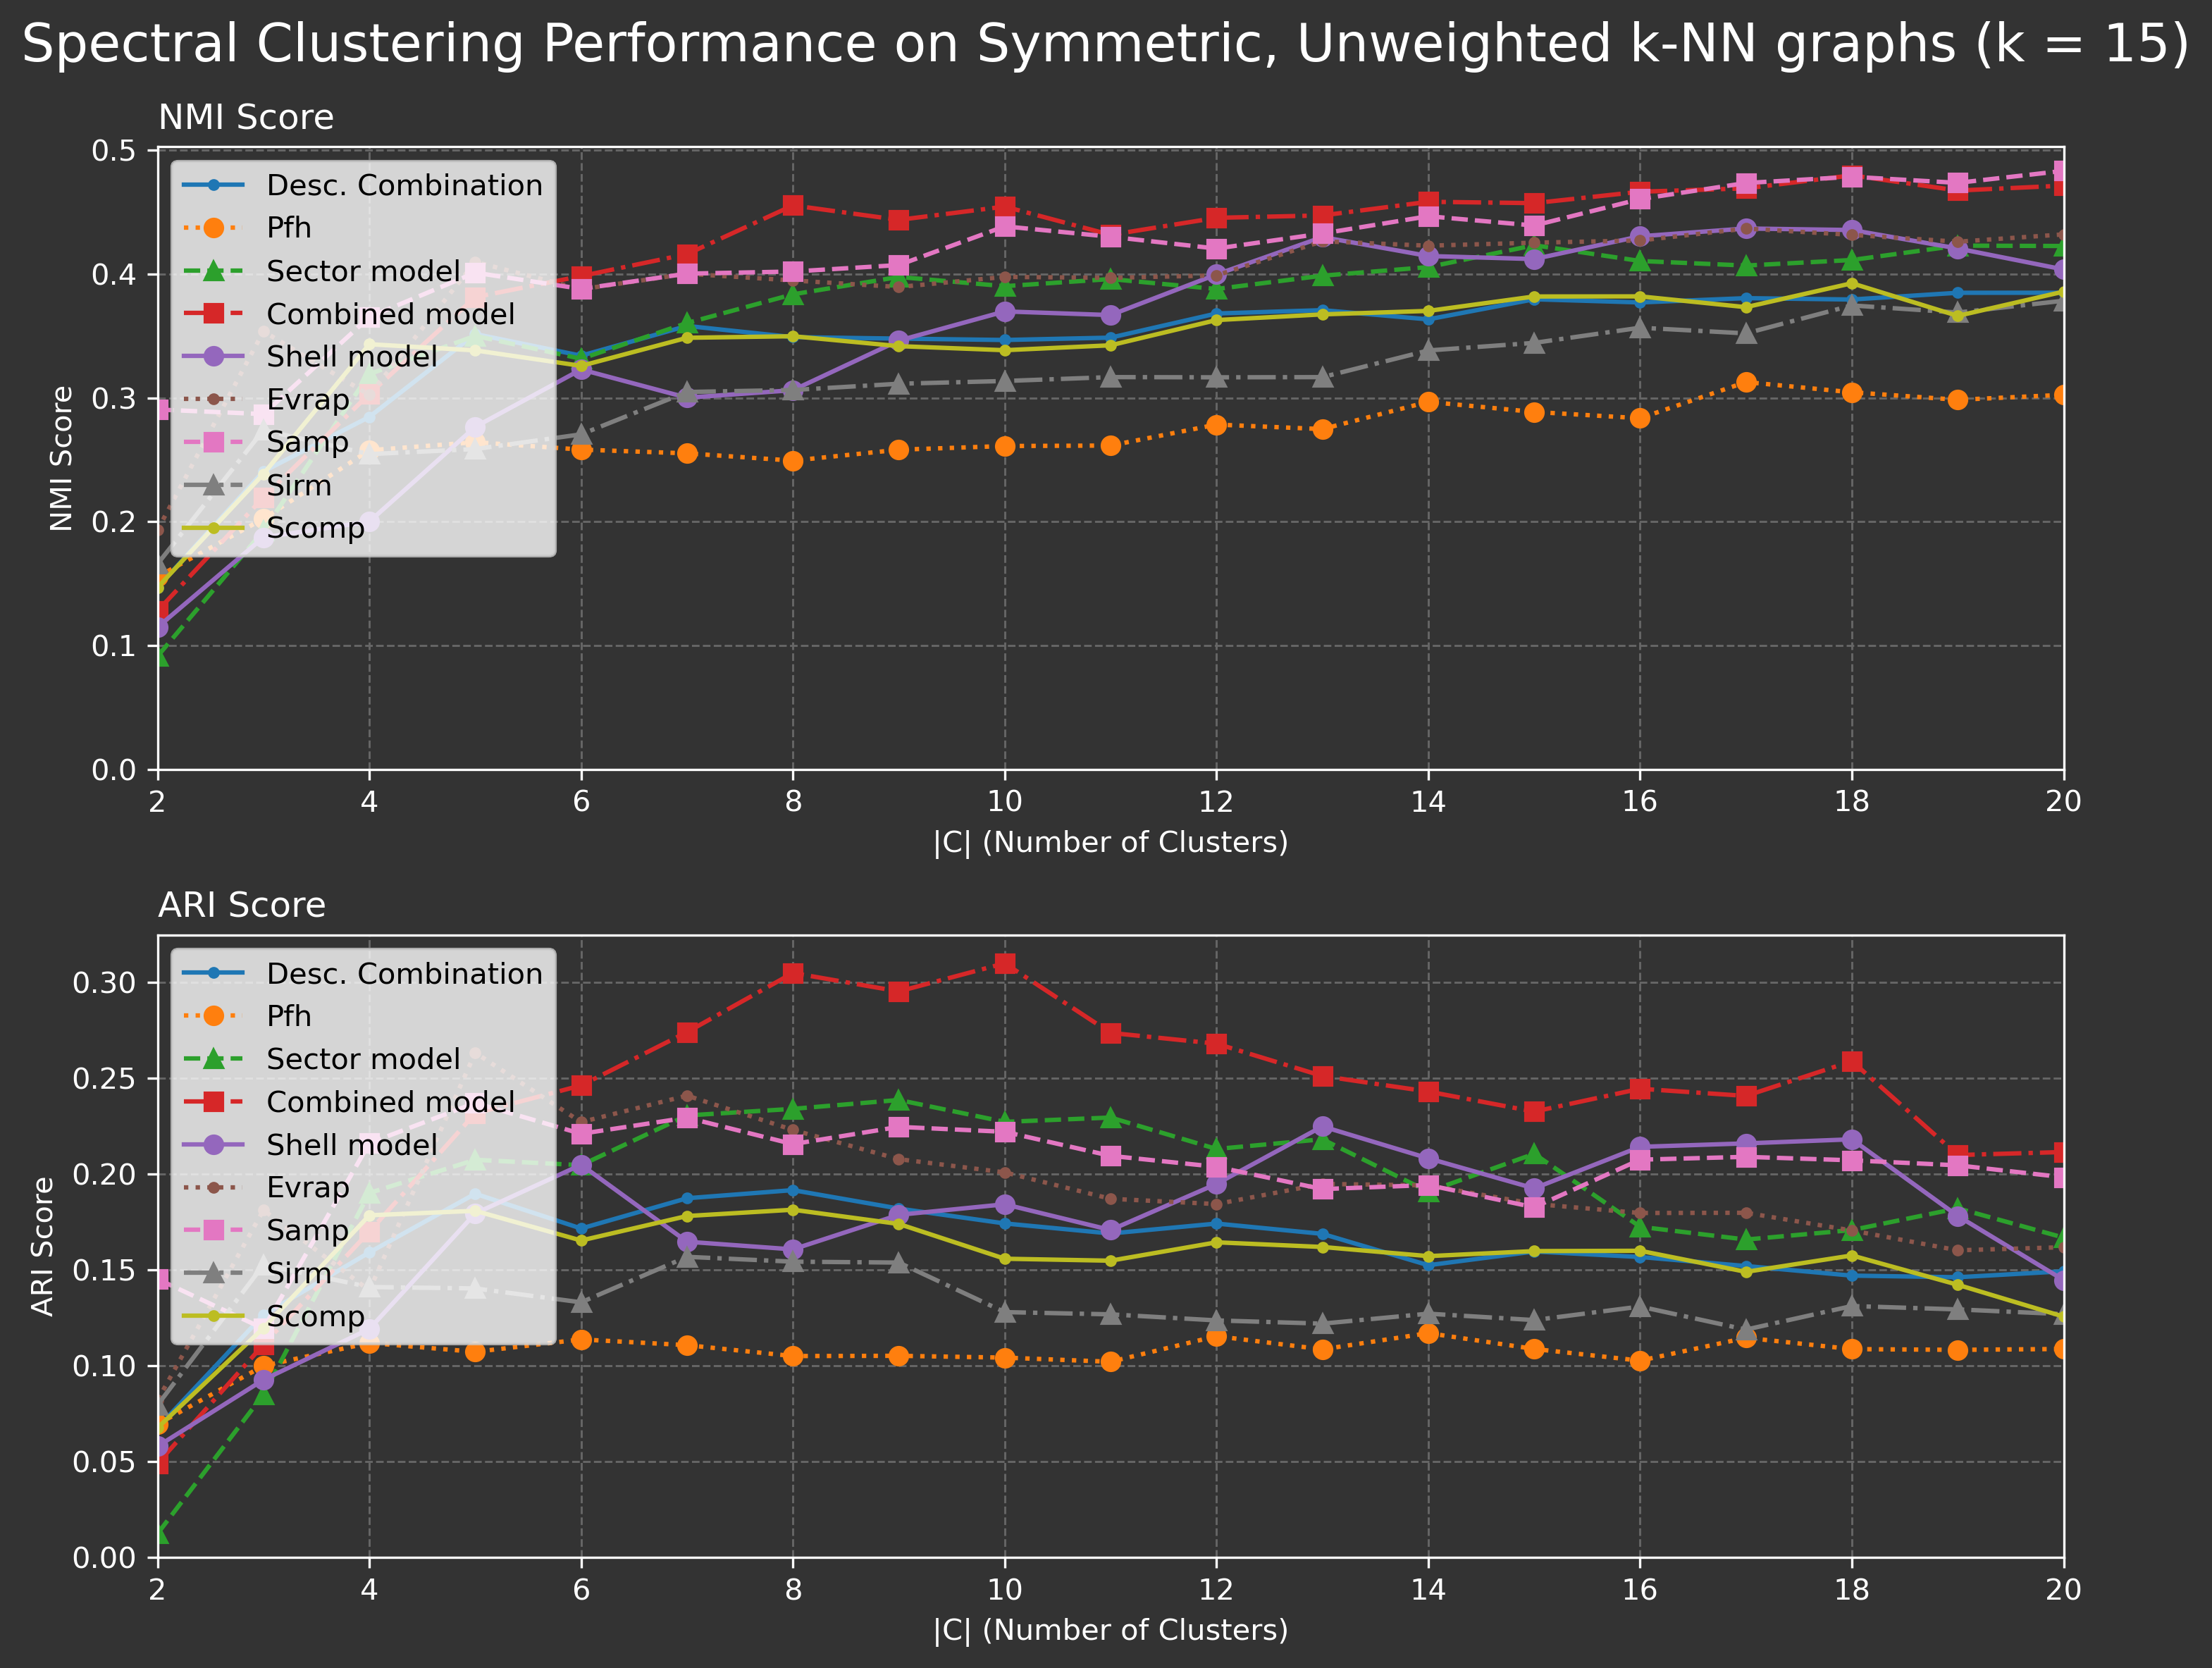

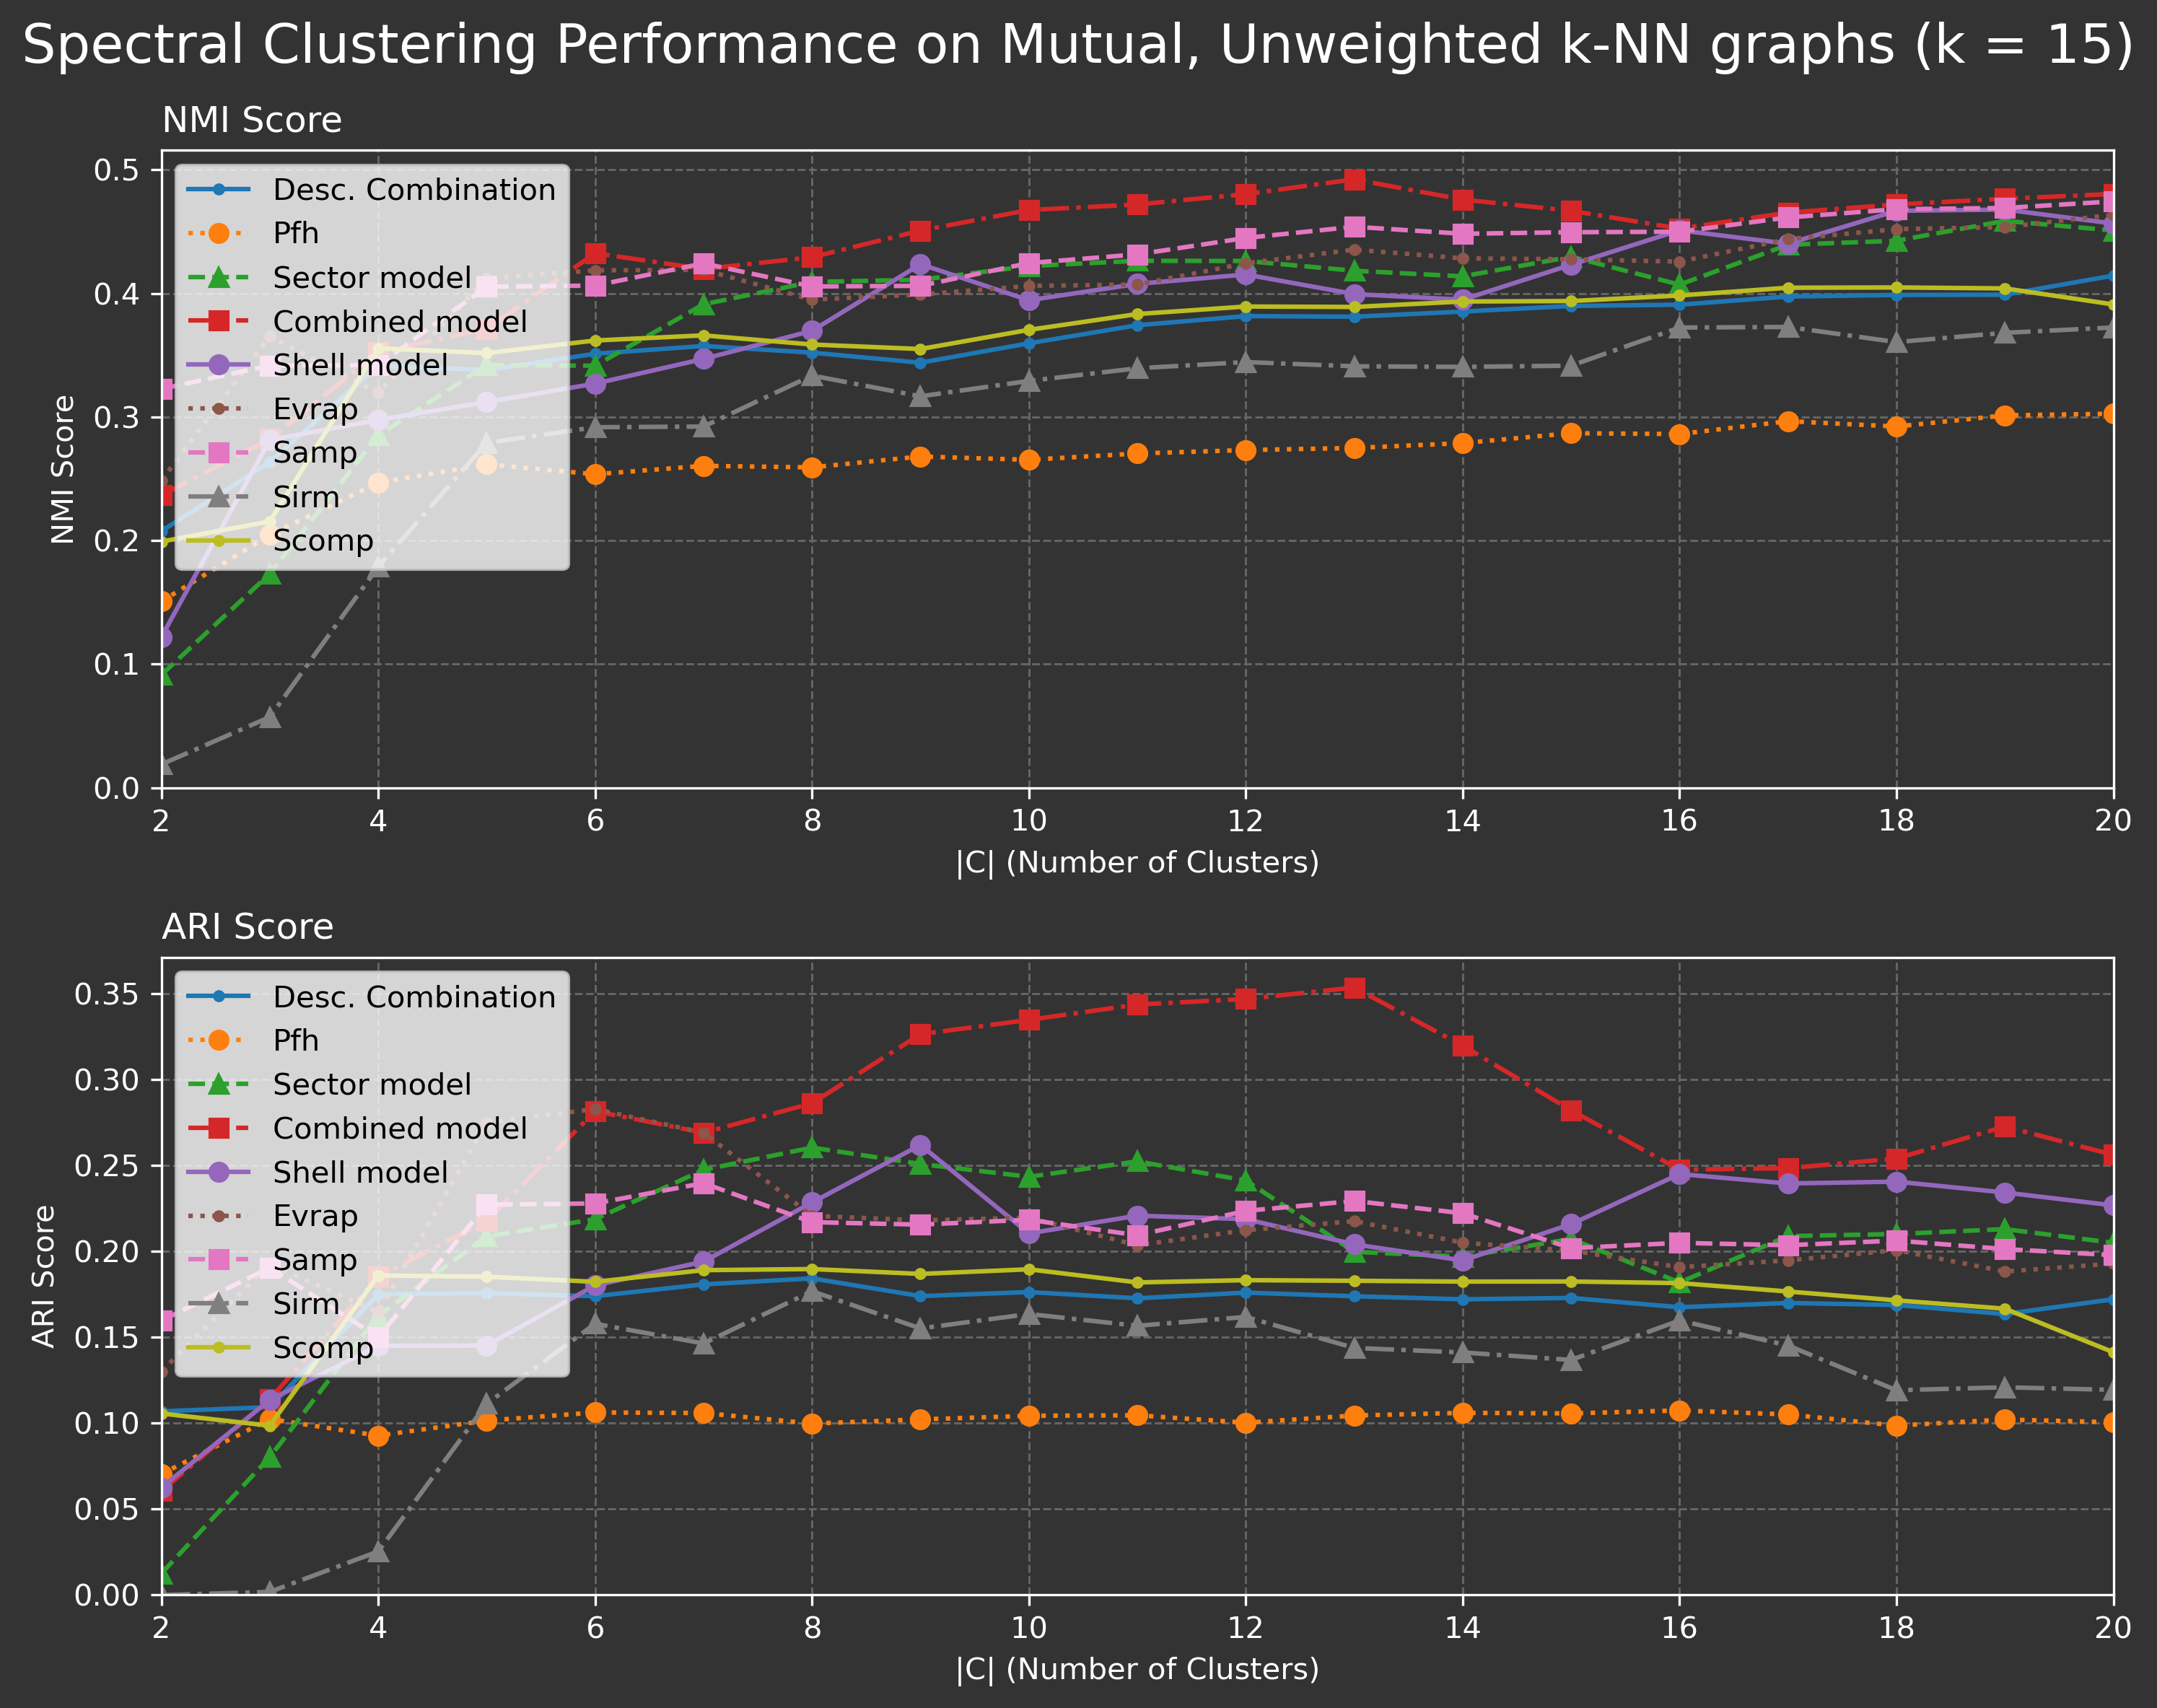

In [173]:
for graph_type in ['symmetric', 'mutual']:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)  # Example with a 2x2 grid of subplots
    
    plot_evaluation(axes[0], descriptors, plot_data_nmi_ari[graph_type]['nmi'], plot_data_nmi_ari['cluster_size'],
                    x_label='|C| (Number of Clusters)', y_label='NMI Score',
                    title='NMI Score')
    
    plot_evaluation(axes[1], descriptors, plot_data_nmi_ari[graph_type]['ari'], plot_data_nmi_ari['cluster_size'],
                    x_label='|C| (Number of Clusters)', y_label='ARI Score',
                    title='ARI Score')
    
    fig.suptitle(f"Spectral Clustering Performance on {graph_type.capitalize()}, {weighted.capitalize()} k-NN graphs (k = {n_neighbors})", color="white", fontsize=18, x=0.01, horizontalalignment="left")
    
    # Set figure background and adjust layout
    fig.patch.set_facecolor('#333333')  # Dark grey background for the figure
    fig.tight_layout()  # Ensure subplots fit within the figure
    
    plt.savefig(f"{weighted}_{graph_type}_knn_nmi_ari_k{n_neighbors}.png")
    plt.show()